# Import Libraries

In [1]:
#import libraries
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

import copy
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import requests

from PIL import Image
from io import BytesIO

# Fetching Data

In [2]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_data = torchvision.datasets.CIFAR10(root='./data',
                                        train= True,
                                        download = True,
                                        transform=transforms.Compose([transforms.ToTensor()]))
val_data = torchvision.datasets.CIFAR10(root='./data',
                                        train= False,
                                        download = True,
                                        transform=transforms.Compose([transforms.ToTensor()]))

Files already downloaded and verified
Files already downloaded and verified


In [3]:
size_batch = 64
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size = size_batch)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size = size_batch)

# Create Model

In [4]:
def create_model():
    model = nn.Sequential(
        
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)       
    )
    
    return model

# Validate Model

In [5]:
def validate(model, data):
    total = 0
    correct = 0
    
    for i, (images, labels) in enumerate(data):
        x = model(images)
        value, pred = torch.max(x, 1)
        total += x.size(0)
        correct += torch.sum(pred == labels)
    
    return correct * 100. / total

# Training Function

In [8]:
def train(numb_epoch = 5, lr = 0.005):
    accuracies = []
    cnn = create_model()
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dataloader):
            
            optimizer.zero_grad()
            grad = cnn(images)
            loss = cec(grad, labels)
            loss.backward()
            optimizer.step()
        
        accuracy = float(validate(cnn, val_dataloader))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            
            print("Saving Best model with accuracy: ", accuracy)
        print("Epoch: ", epoch+1, "Accuracy:", accuracy, "%")
    plt.plot(accuracies)
    return best_model

# Training Model

Saving Best model with accuracy:  55.150001525878906
Epoch:  1 Accuracy: 55.150001525878906 %
Saving Best model with accuracy:  66.38999938964844
Epoch:  2 Accuracy: 66.38999938964844 %
Saving Best model with accuracy:  72.0999984741211
Epoch:  3 Accuracy: 72.0999984741211 %
Epoch:  4 Accuracy: 70.7699966430664 %
Saving Best model with accuracy:  74.93000030517578
Epoch:  5 Accuracy: 74.93000030517578 %


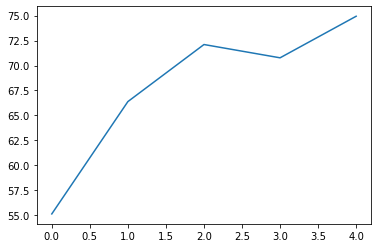

In [9]:
best_model = train(5)

# Prediction Function

In [12]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images,labels) in enumerate(data):
        x = model(images)
        value, pred = torch.max(x, 1)
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    
    return np.array(y_pred), np.array(y_true)

In [14]:
y_pred, y_true = predict_dl(best_model, val_dataloader)
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

,0,1,2,3,4,5,6,7,8,9
0,718,17,85,33,12,3,4,21,78,29
1,11,884,1,12,2,3,7,3,25,52
2,33,3,613,97,117,28,44,44,20,1
3,12,7,54,669,56,83,48,46,18,7
4,14,4,38,73,715,17,26,99,11,3
5,7,3,26,258,44,574,12,67,6,3
6,4,1,31,98,54,8,776,8,16,4
7,6,4,14,57,32,33,7,840,2,5
8,26,14,7,17,2,1,4,7,910,12
9,18,78,4,33,2,0,7,20,44,794


# Custom Input Function

In [42]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def predict_custom(path, model):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        img = Image.open(f).convert('RGB')
        img = img.resize((32,32))
        x = (255 - np.expand_dims(np.array(img), -1)) / 255
        t = torch.from_numpy(x.squeeze())
        plt.imshow(x.squeeze(-1))
        
    with torch.no_grad():
        x = t.numpy()
        pred = model(torch.unsqueeze(T(x), axis = 0).float())
        pred = F.softmax(pred, dim= -1).numpy()
        pred_idx = np.argmax(pred)
        print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")        
        return classes[pred_idx]

# Custom Input Predict

Predicted: 2, Prob: 90.52472710609436 %
bird


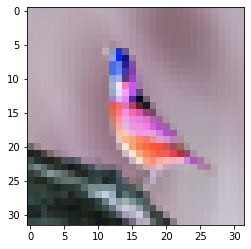

In [43]:
path = 'https://cdn.download.ams.birds.cornell.edu/api/v1/asset/202984001/1200'
pred = predict_custom(path,best_model)
print(pred)